#Spatial Segmentation of running section

To realize the spatial segmentation a grid oriented in the direction of the average trajectory mm x mm of the animal is ceated. From the neurolib library the Trajectory variable is a dictionary containing the average position of the rat across interpolated laps (to the slowest lap)

In [24]:
import neurolib as nl
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

folder = '/media/bigdata/'
names = nl.find_files(folder)

Populating the interactive namespace from numpy and matplotlib
/media/bigdata/i01_maze13.003/i01_maze13_MS.003_BehavElectrData.mat
/media/bigdata/i01_maze06.002/i01_maze06_MS.002_BehavElectrData.mat
/media/bigdata/i01_maze08.001/i01_maze08_MS.001_BehavElectrData.mat
/media/bigdata/i01_maze15.002/i01_maze15_MS.002_BehavElectrData.mat
/media/bigdata/i01_maze08.004/i01_maze08_MS.004_BehavElectrData.mat
/media/bigdata/i01_maze06.005/i01_maze06_MS.005_BehavElectrData.mat
/media/bigdata/i01_maze05.005/i01_maze05_MS.005_BehavElectrData.mat


In [38]:
animal = 2
cells, trajectory, duration = nl.get_cells(names[animal][1], only_pyr=True, section='Run')

num_cells, num_laps, _ = np.shape(cells['xy'])
right_task = trajectory['right']
left_task = trajectory['left']
print '{} left and {} right alternations'.format(len(left_task), len(right_task))

Skipping lap 0 because animal failed it
Skipping lap 13 because animal failed it
Skipping lap 15 because animal failed it
81 cells extracted
/media/bigdata/i01_maze08.001/i01_maze08_MS.001_BehavElectrData.mat Loading completed
14 left and 11 right alternations


Show the estereotypical positions of the animal in the right and left arm of the maze caculate by the median value all the laps

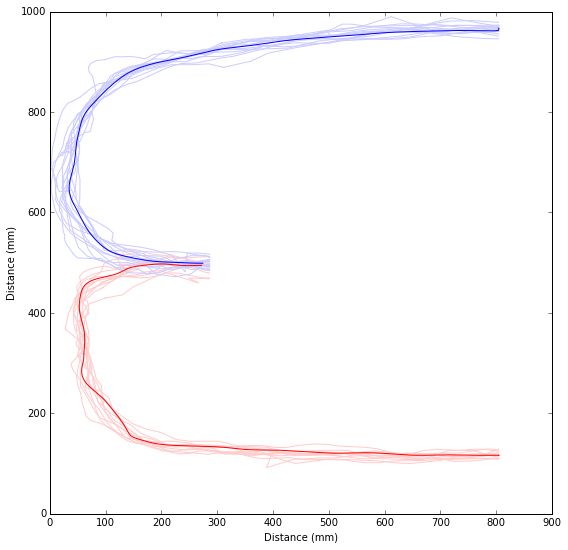

In [39]:
plt.figure(num=None, figsize=(9,9), dpi=150)

for ind, ri in enumerate(right_task):
    plt.plot(ri[0], ri[1], color=[1, 0.8, 0.8])

for ind, le in enumerate(left_task):
    plt.plot(le[0], le[1], color=[0.8, 0.8, 1.0])
plt.xlabel('Distance (mm)')
plt.ylabel('Distance (mm)')

path_left = np.array(trajectory['left_median'])
path_right = np.array(trajectory['right_median'])
plt.plot(path_left[0], path_left[1], color='b')
plt.plot(path_right[0], path_right[1], color='r')


Define the size of the spatial bin and contruct the regios of interest (ROIs) or what is the same in this context, the spatial bins

In [63]:
bin_shape = np.array([20, 100])
centers_left, rois_left = nl.construct_rois(bin_shape, path_left)
centers_right, rois_right = nl.construct_rois(bin_shape, path_right)
num_rois = min(len(rois_right), len(rois_left))
print 'Number of bins extracted {}, approx. {} ms per bin'.format(num_rois, len(path_left[0])/(1.250*num_rois))

Number of bins extracted 60, approx. 82.9466666667 ms per bin


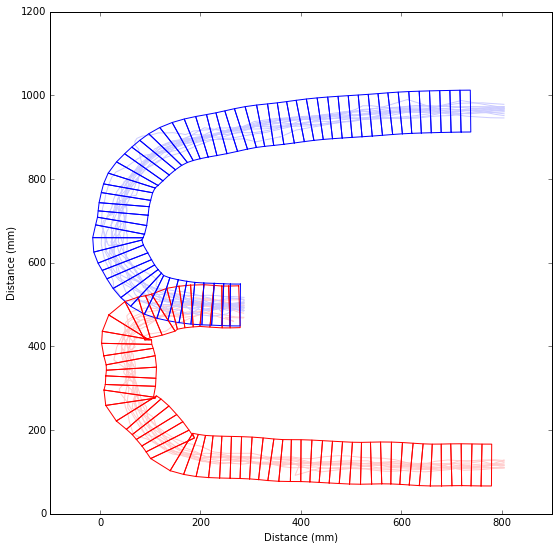

In [64]:
#ploting animal position in all laps as ghost traces
plt.figure(num=None, figsize=(9,9), dpi=150)

for ind, ri in enumerate(right_task):
    plt.plot(ri[0], ri[1], color=[1, 0.8, 0.8])
for ind, le in enumerate(left_task):
    plt.plot(le[0], le[1], color=[0.8, 0.8, 1.0])
plt.xlabel('Distance (mm)')
plt.ylabel('Distance (mm)')
#showing the rois generated
for bi_le, bi_ri in zip(rois_left, rois_right):
    plt.plot(bi_ri[0], bi_ri[1], 'r')
    plt.plot(bi_le[0], bi_le[1], 'b')
    

Note that bins are connected, that is, there is not gap between adyacent bins.

Count the spikes of each cell, on each bin, for each lap

Counting only successful laps
####Counting spikes lap 1#####
####Counting spikes lap 2#####
####Counting spikes lap 3#####
Cell 10 = 12, counted 12<<<debug
####Counting spikes lap 4#####
####Counting spikes lap 5#####
####Counting spikes lap 6#####
####Counting spikes lap 7#####
####Counting spikes lap 8#####
####Counting spikes lap 9#####
####Counting spikes lap 10#####
####Counting spikes lap 11#####
####Counting spikes lap 12#####
####Counting spikes lap 14#####
####Counting spikes lap 16#####
####Counting spikes lap 17#####
####Counting spikes lap 18#####
####Counting spikes lap 19#####
####Counting spikes lap 20#####
####Counting spikes lap 21#####
####Counting spikes lap 22#####
####Counting spikes lap 23#####
####Counting spikes lap 24#####
####Counting spikes lap 25#####
####Counting spikes lap 26#####
####Counting spikes lap 27#####


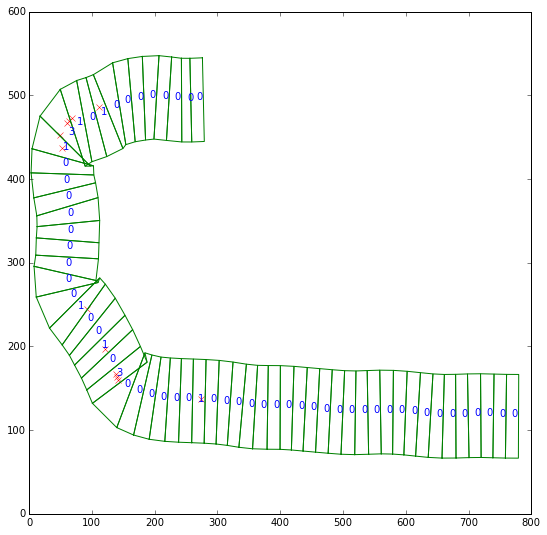

In [65]:
#Traspose spikes to have it with dimension Laps x cells_xy
spikes_xy = map(list,zip(*cells['xy']))
verbose = True
lap_verbose = 3
cell_verbose = 10
#spike counts with dims Cells x (bins) x Laps 
spk_count = np.zeros([num_cells, num_rois , num_laps])
print 'Counting only successful laps'

# this loop iterates laps
for n_lap, cell in enumerate(spikes_xy):
    #left of right arm
    if cells['hit'][n_lap]:
        rois = rois_right[:num_rois]
        centers = centers_right[:num_rois]
        if cells['direction'][n_lap] == 1 or cells['direction'][n_lap] == 4:
            rois = rois_left[:num_rois]
            centers = centers_left[:num_rois]
        print '####Counting spikes lap {}#####'.format(n_lap)

        #this loop iterates cells
        for n_cell, spks in enumerate(cell): 
            count = 0
            if len(spks[0]) != 0:
                count = nl.multi_point_in_poly(spks[0], spks[1], rois)             
                assert (len(spks[0][2:]) - sum(count[2:])) < 10, 'More than 10 spikes not counted ({})'.format((len(spks[0]) - sum(count))) 
                spk_count[n_cell, :, n_lap] = count
            if verbose and lap_verbose==n_lap and cell_verbose==n_cell:
                print 'Cell {} = {}, counted {}<<<debug'.format(n_cell, len(spks[0]), sum(count))
                plt.figure(num=None, figsize=(9,9), dpi=150)
                plt.plot(spks[0], spks[1],'rx')
                
                #show rois
                r = 0
                for bi_le, c in zip(rois, centers):                
                    plt.plot(bi_le[0], bi_le[1], 'g') 
                    plt.text(c[0], c[1], '{}'.format(count[r]), color='b')
                    r += 1


In [66]:
all_spks = spk_count.reshape([num_cells, -1])
keep_cells = np.mean(all_spks,axis=1) > 0.01
num_cells_active = sum(keep_cells)
num_laps_hit = sum(cells['hit'])

print 'Number of cells after removing silent ones = {}'.format(num_cells_active)
non_silent = np.reshape(all_spks[keep_cells, :], [num_cells_active,num_rois, num_laps])
D_cells = non_silent[:, : ,cells['hit']].copy()

Number of cells after removing silent ones = 54


In [67]:
#Calculate the time the animal spent on each ROI for normalization
pos = trajectory['all_traj']
norm_roi = np.zeros([ num_rois, num_laps_hit ])
cnt = 0
for n_lap in range(num_laps):
    if cells['hit'][n_lap]:
        traj = pos[n_lap]
        #select the rois left/right
        rois = rois_right[:num_rois]
        if cells['direction'][n_lap] == 1 or cells['direction'][n_lap] == 4:
            rois = rois_left[:num_rois]
            
        count = nl.multi_point_in_poly(traj[0], traj[1], rois)
        norm_roi[ : , cnt] = count
        cnt += 1
print 'Normalization matrix created with dimensions {}'.format(np.shape(norm_roi))        


Normalization matrix created with dimensions (60, 25)


In [68]:
#normalize the spikes by their duration
D_normalized = D_cells/((norm_roi + 1)/1250.)

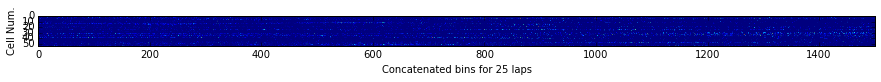

In [69]:
plt.figure(num=None, figsize=(15,5), dpi=150)
plt.imshow(D_normalized.reshape([num_cells_active, -1]))
plt.ylabel('Cell Num.')
plt.xlabel('Concatenated bins for {} laps'.format(num_laps_hit))
fig_name = names[animal][1][:-4] + 'normSpikes.png'
savefig(fig_name, dpi=600, bbox_inches='tight')

In [70]:
#sparseness ratio
non_zero = np.count_nonzero(D_normalized)
num_elements =  np.prod(np.shape(D_normalized))
print 'Non zero elements {} of {} ({}%)'.format(non_zero,num_elements, 100*float(non_zero)/float(num_elements))

Non zero elements 7861 of 81000 (9.7049382716%)
